In [7]:
import pandas as pd
from collections import Counter
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes import Axes
from  sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics.cluster import contingency_matrix

In [ ]:
! python core/CoDi.py --st_path /goofys/Samples/10X/human_myocardial_infarction/Visium_control_P7.h5ad --sc_path /goofys/Samples/sc_reference/heartcellatlas/Global_norm_markers.h5ad -a cell_type -v
# # Human heart dataset
# python CoDi.py --st_path /goofys/Samples/sc_reference/GSE121893_heart_4933_cells.h5ad --sc_path /goofys/Samples/sc_reference/GSE183852_heart.h5ad -a cell_type --n_jobs 50

In [2]:
st_path = '/goofys/Samples/10X/human_heart/visium-OCT_LV_lognormalised.h5ad'
st_path = '/goofys/Samples/10X/human_heart/visium-OCT_RV_lognormalised.h5ad'
st_path = '/goofys/Samples/10X/human_heart/visium-OCT_LA_lognormalised.h5ad'
st_path = '/goofys/Samples/10X/human_heart/visium-OCT_RA_lognormalised.h5ad'
st_path = '../visium-OCT_RA_lognormalised_ssi_KLD.h5ad'
st_path = '../visium-OCT_SAN_lognormalised_ssi_KLD.h5ad'  # 77 Neurons, 253 nerve
st_path = '../visium-FFPE_SAN_lognormalised_ssi_KLD.h5ad'
st_path = '/goofys/Samples/10X/human_myocardial_infarction/Visium_control_P7.h5ad'
st_path = '../Visium_control_P7_ssi_KLD_heartcellatlas.h5ad'
st_path = '../Visium_control_P7_ssi_KLD.h5ad'
st_path = '/goofys/Samples/10X/human_myocardial_infarction/Visium_control_P7.h5ad'
st_path = '../Visium_control_P7_CoDi_KLD.h5ad'
adata_st = sc.read_h5ad(st_path)
adata_st

AnnData object with n_obs × n_vars = 2931 × 14492
    obs: 'n_counts', 'n_genes', 'percent.mt', 'Adipocyte', 'Cardiomyocyte', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal', 'Pericyte', 'Cycling.cells', 'vSMCs', 'cell_type_original', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'CoDi_dist', 'CoDi_confidence_dist', 'CoDi_contrastive', 'CoDi_confidence_contrastive', 'CoDi', 'CoDi_confidence'
    var: 'features'
    uns: 'X_approximate_distribution', 'X_normalization', 'default_embedding', 'schema_version', 'title'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'probabilities', 'probabilities_contrastive', 'probabilities_dist', 'spatial'

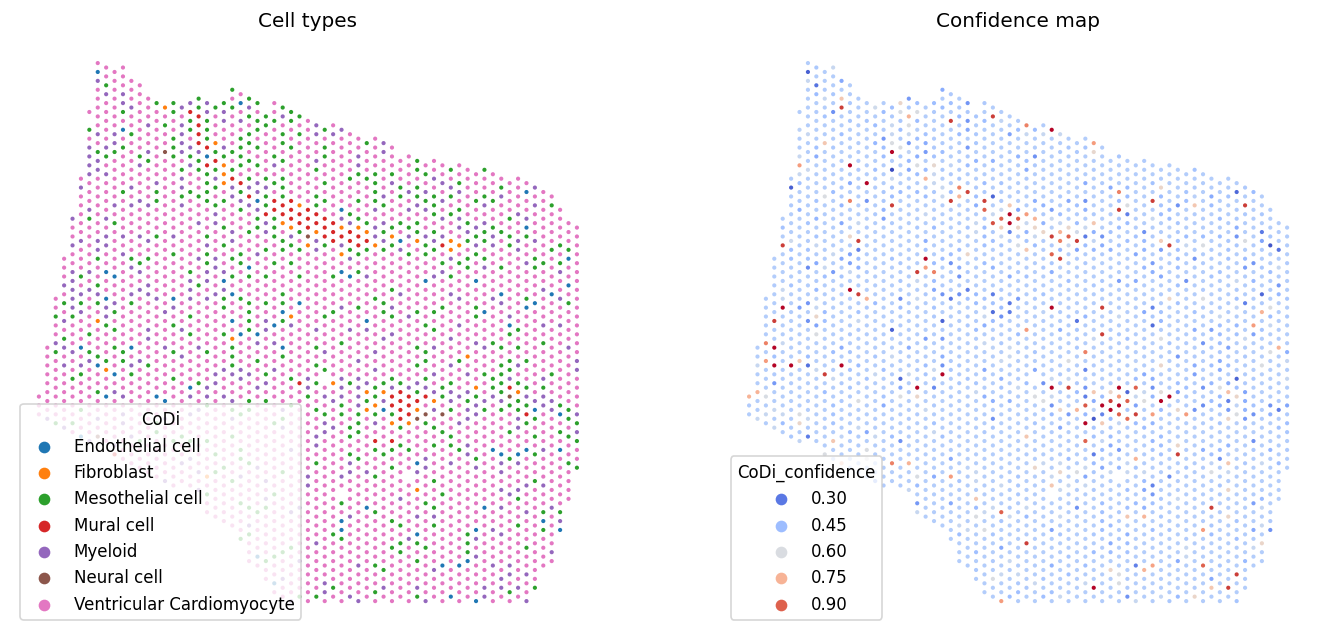

In [3]:
from IPython.display import Image
display(Image(filename='../Visium_control_P7_CoDi_KLD.png'))

In [52]:
cluster_palette = ["#d62728", "#ff7f0e", "#279e68", "#aa40fc", \
                  "#e377c2", "#b5bd61", "#17becf", "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", \
                  "#c5b0d5", "#c49c94", "#f7b6d2", "#dbdb8d", "#9edae5", "#ad494a", "#8c6d31", \
                  "#b4d2b1", "#568f8b", "#1d4a60", "#cd7e59", "#ddb247", "#d15252", \
                  "#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51", "#ef476f", \
                  "#ffd166","#06d6a0","#118ab2","#073b4c", "#fbf8cc","#fde4cf", \
                  "#ffcfd2","#f1c0e8","#cfbaf0","#a3c4f3","#90dbf4","#8eecf5", \
                  '#8359A3', '#5e503f', '#33CC99', '#F2C649', '#B94E48', '#0095B7']


def plot_spatial(
    adata, annotation, ax: Axes, spot_size: float, palette=cell_type_palette_dict, title: str = "", legend='auto'
):
    """
    Scatter plot in spatial coordinates.

    Parameters:
        - adata (AnnData): Annotated data object which represents the sample
        - annotation (str): adata.obs column used for grouping
        - ax (Axes): Axes object used for plotting
        - spot_size (int): Size of the dot that represents a cell. We are passing it as a diameter of the spot, while
                the plotting library uses radius therefore it is multiplied by 0.5
        - palette (dict): Dictionary that represents a mapping between annotation categories and colors
        - title (str): Title of the figure

    """
    s = spot_size * 0.5
    data = adata
    ax = sns.scatterplot(
        data=data.obs,
        hue=annotation,
        x=data.obsm["spatial"][:, 0],
        y=data.obsm["spatial"][:, 1],
        ax=ax,
        s=s,
        linewidth=0,
        palette=palette,
        marker=".",
        legend=legend
    )
    ax.invert_yaxis()
    ax.set(yticklabels=[], xticklabels=[], title=title)
    ax.tick_params(bottom=False, left=False)
    ax.set_aspect("equal")
    sns.despine(bottom=True, left=True, ax=ax)


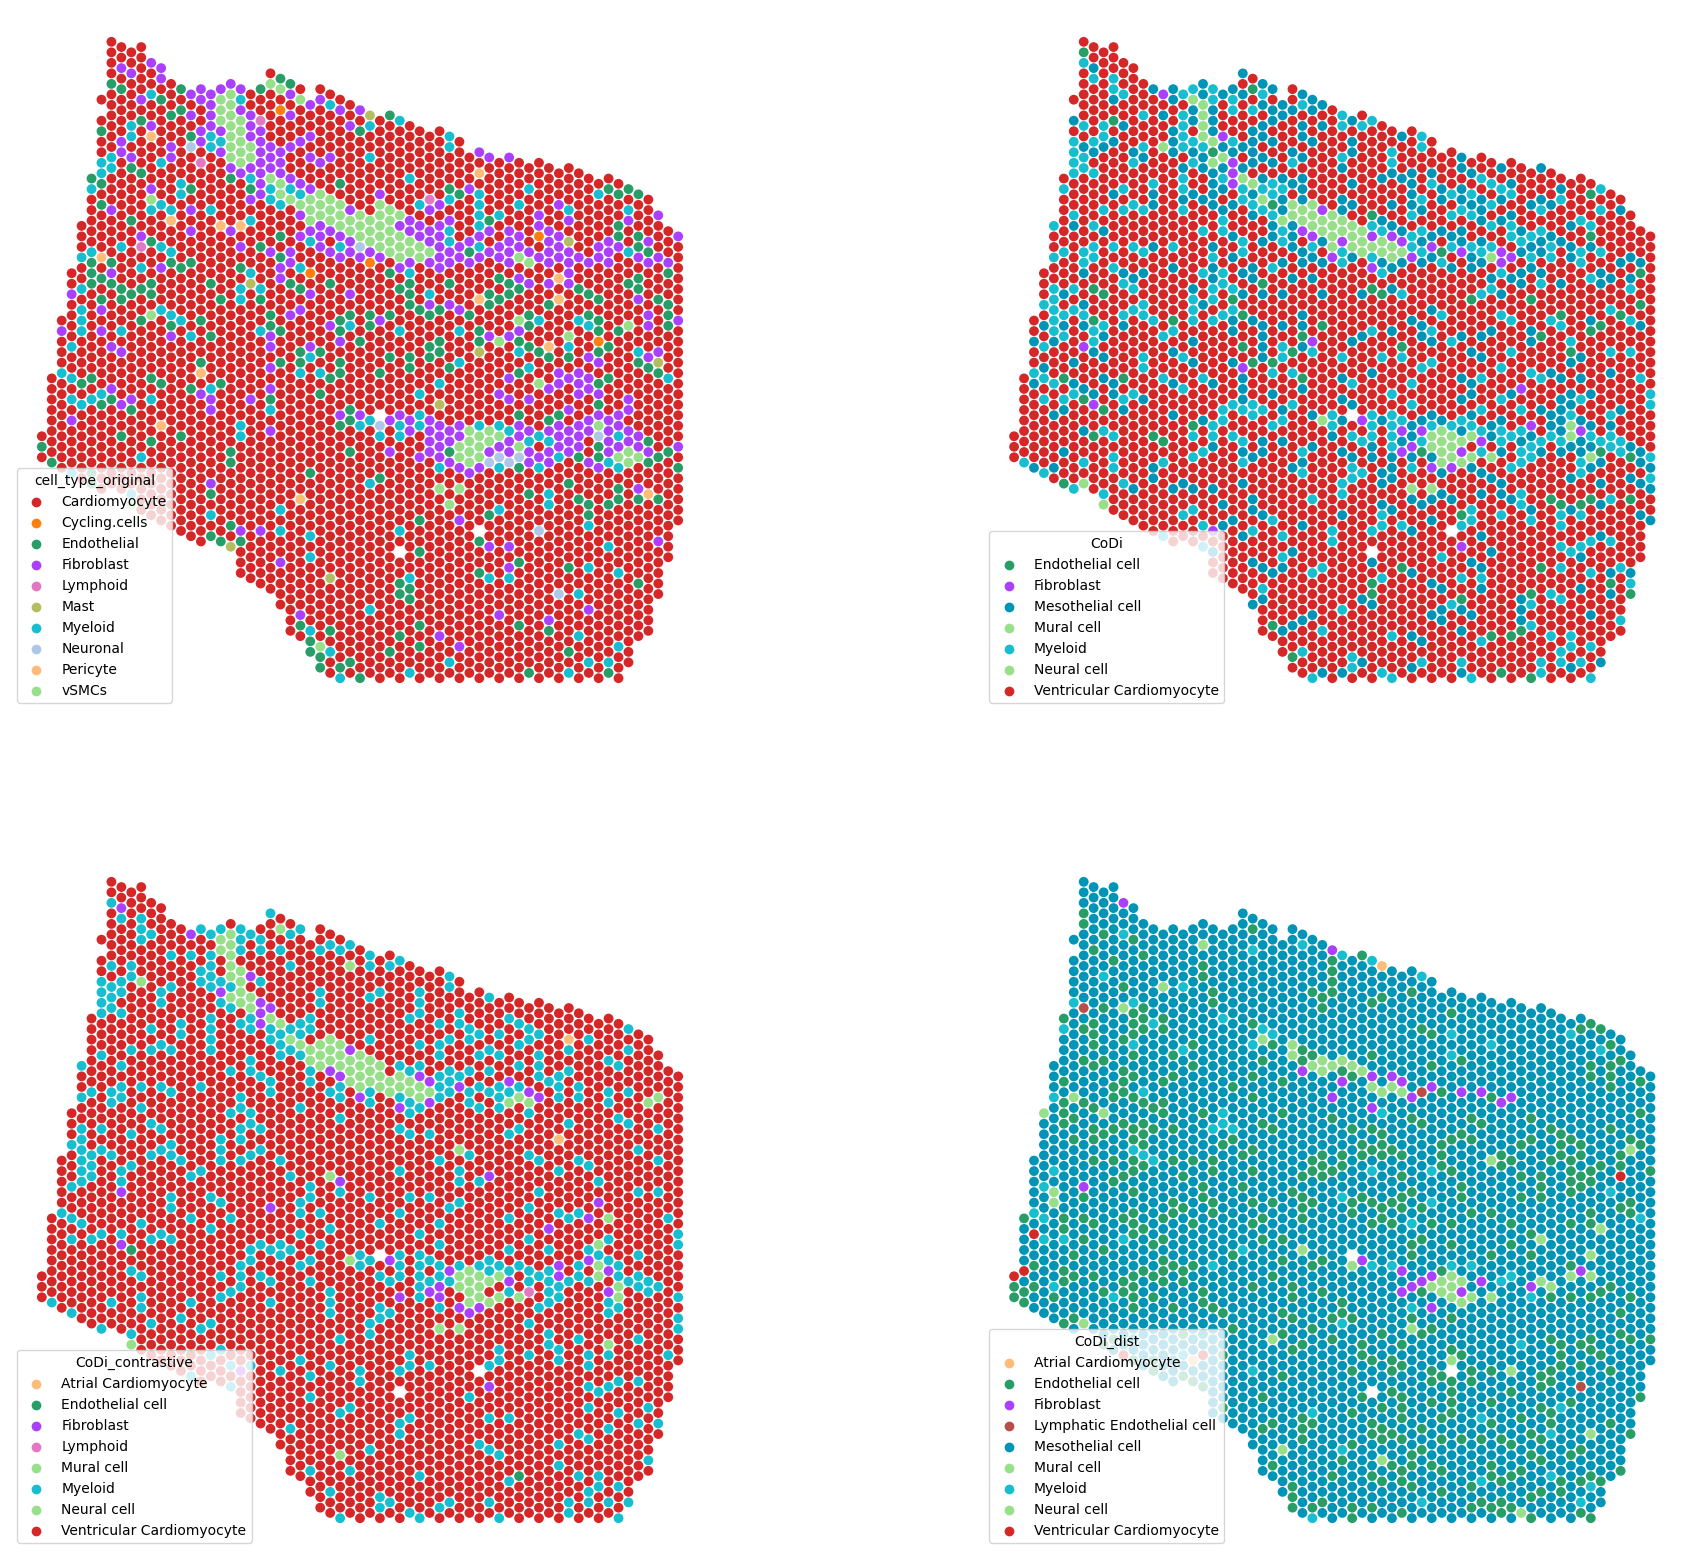

In [54]:
spot_size = 400
annotation = 'cell_type_original'
cell_type_palette_dict = dict(zip(sorted(adata_st.obs[annotation].unique()), cluster_palette))
fig, axs = plt.subplots(2, 2, figsize=(23, 20))
plot_spatial(adata_st, annotation=annotation, palette=cell_type_palette_dict, spot_size=spot_size, ax=axs[0][0])

codi_palette_dict = {'Ventricular Cardiomyocyte': cluster_palette[0], 'Myeloid': cluster_palette[6], 
                     'Mesothelial cell': cluster_palette[-1], 'Endothelial cell': cluster_palette[2],
                     'Mural cell': cluster_palette[9], 'Fibroblast': cluster_palette[3], 
                     'Neural cell': cluster_palette[9], 'Atrial Cardiomyocyte': cluster_palette[8],
                    'Lymphoid': cluster_palette[4], 'Lymphatic Endothelial cell': cluster_palette[-2]}
plot_spatial(adata_st, annotation='CoDi', palette=codi_palette_dict, spot_size=spot_size, ax=axs[0][1])
plot_spatial(adata_st, annotation='CoDi_contrastive', palette=codi_palette_dict, spot_size=spot_size, ax=axs[1][0])
plot_spatial(adata_st, annotation='CoDi_dist', palette=codi_palette_dict, spot_size=spot_size, ax=axs[1][1])
plt.savefig('Visium_control_P7_CoDi.png', dpi=300, bbox_inches='tight')

In [25]:
adata_st.obs['CoDi'].unique()

['Ventricular Cardiomyocyte', 'Myeloid', 'Mesothelial cell', 'Endothelial cell', 'Mural cell', 'Fibroblast', 'Neural cell']
Categories (7, object): ['Ventricular Cardiomyocyte', 'Myeloid', 'Mesothelial cell', 'Endothelial cell', 'Mural cell', 'Fibroblast', 'Neural cell']

In [48]:
sorted(adata_st.obs['CoDi_contrastive'].unique())

['Atrial Cardiomyocyte',
 'Endothelial cell',
 'Fibroblast',
 'Lymphoid',
 'Mural cell',
 'Myeloid',
 'Neural cell',
 'Ventricular Cardiomyocyte']

Text(0.5, 1.0, 'Contingency Matrix')

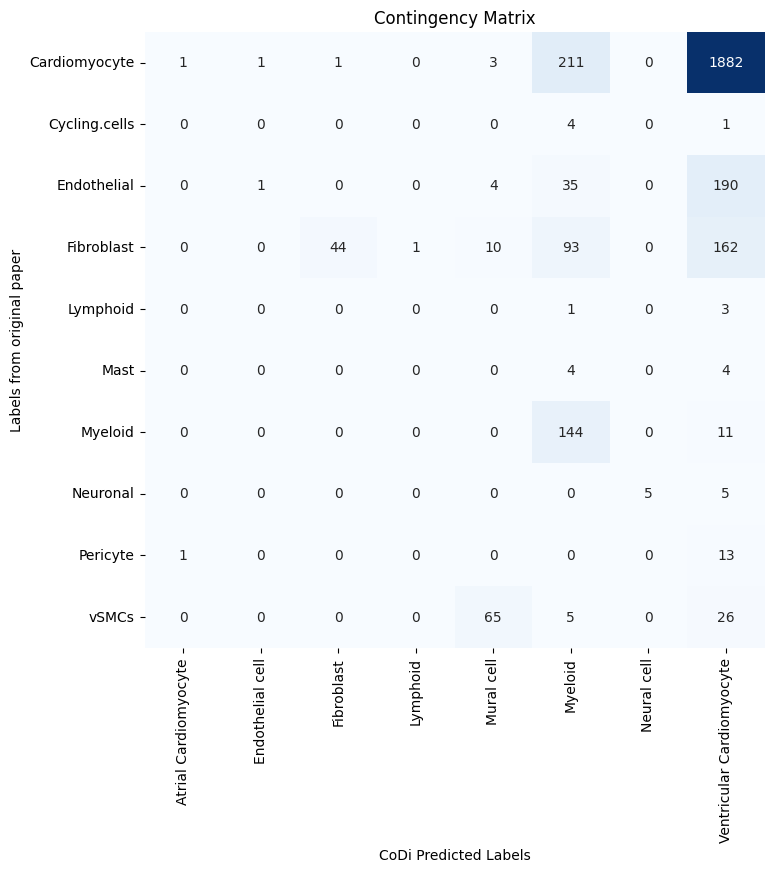

In [47]:
out_name = st_path.split('/')[-1].replace('.h5ad', '_codi_contingency.png')
cm = contingency_matrix(adata_st.obs.loc[:, 'cell_type_original'], adata_st.obs.loc[:, 'CoDi_contrastive'])
# Visualize the confusion matrix using Seaborn
class_labels_y = np.unique(adata_st.obs.loc[:, 'cell_type_original'])
class_labels_x = np.unique(adata_st.obs.loc[:, 'CoDi_contrastive'])

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels_x, yticklabels=class_labels_y)
plt.xlabel("CoDi Predicted Labels")
plt.ylabel("Labels from original paper")
plt.title("Contingency Matrix")
# plt.savefig(out_name, dpi=300, bbox_inches='tight')

In [17]:
out_name = st_path.split('/')[-1].replace('.h5ad', '_codi_contingency.png')
cm = contingency_matrix(adata_st.obs.loc[:, 'cell_type_original'], adata_st.obs.loc[:, 'CoDi'])
# Visualize the confusion matrix using Seaborn
class_labels_y = np.unique(adata_st.obs.loc[:, 'cell_type_original'])
class_labels_x = np.unique(adata_st.obs.loc[:, 'CoDi'])

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels_x, yticklabels=class_labels_y)
plt.xlabel("CoDi Predicted Labels")
plt.ylabel("Labels from original paper")
plt.title("Contingency Matrix")
# plt.savefig(out_name, dpi=300, bbox_inches='tight')

In [2]:
sc_path = '/goofys/Samples/sc_reference/heartcellatlas/Global_norm_markers.h5ad'
adata_sc = sc.read_h5ad(sc_path)
adata_sc

/home/vlada/miniconda3/envs/svc/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 704296 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene ID', 'gene_name-new', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'donor_type_colors', 'facil

In [4]:
list(adata_sc.obs['cell_type'].unique())

['Endothelial cell',
 'Mural cell',
 'Myeloid',
 'Fibroblast',
 'Lymphoid',
 'Neural cell',
 'Ventricular Cardiomyocyte',
 'Lymphatic Endothelial cell',
 'Mesothelial cell',
 'Atrial Cardiomyocyte',
 'Mast cell',
 'Adipocyte']

In [6]:
len(adata_sc[adata_sc.obs['cell_type'] == 'Neural cell'])

6622

In [81]:

# sc.pl.spatial(adata_st, color='cell_type_original', library_id=None, spot_size=0.015)  # ['HCAHeartST8795933', 'HCAHeartST9383352', 'HCAHeartST9383354', 'HCAHeartST9383356', 'HCAHeartST9383358']
# plt.savefig(out_name, dpi=300, bbox_inches='tight')

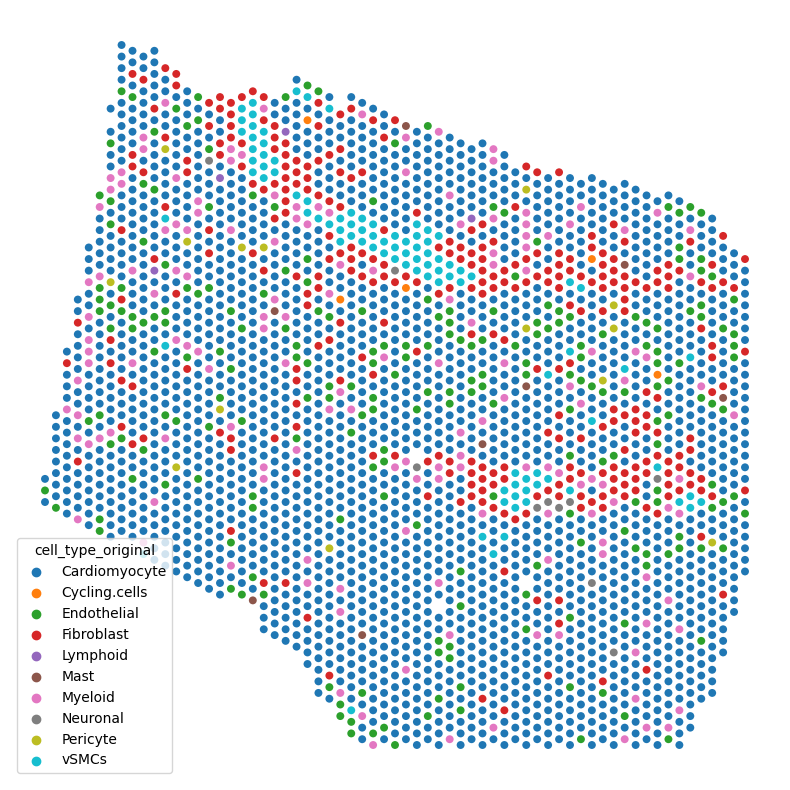

In [82]:
out_name = st_path.split('/')[-1].replace('.h5ad', '_all.png')
adata_st.obsm['spatial'] = adata_st.obsm['X_spatial']
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
plot_spatial(
    adata_st,
    annotation=f"cell_type_original",
    spot_size=260,
    ax=axs
)
plt.savefig(out_name, dpi=300, bbox_inches='tight')

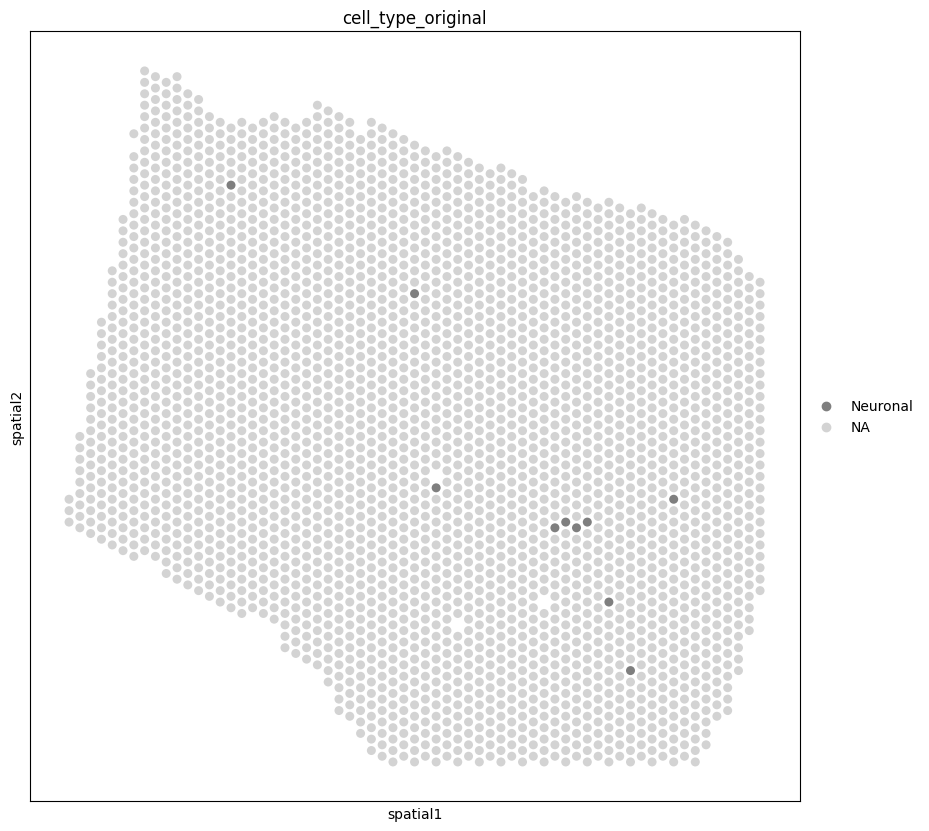

In [83]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
out_name = st_path.split('/')[-1].replace('.h5ad', '_original_neurons.png')
sc.pl.spatial(adata_st, color='cell_type_original', library_id=None, spot_size=0.013, groups=['Neuronal'], ax=axs, save=out_name)  # ['HCAHeartST8795933', 'HCAHeartST9383352', 'HCAHeartST9383354', 'HCAHeartST9383356', 'HCAHeartST9383358']


In [84]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
out_name = st_path.split('/')[-1].replace('.h5ad', '_codi_neurons.png')
sc.pl.spatial(adata_st, color='ssi', library_id=None, spot_size=0.013, groups=['Neural cell'], ax=axs, save=out_name)  # ['HCAHeartST8795933', 'HCAHeartST9383352', 'HCAHeartST9383354', 'HCAHeartST9383356', 'HCAHeartST9383358']

In [85]:
len(adata_st)

2931

In [86]:
Counter(adata_st.obs['ssi'])

Counter({'Mesothelial cell': 2154,
         'Endothelial cell': 594,
         'Myeloid': 81,
         'Fibroblast': 43,
         'Neural cell': 29,
         'Mural cell': 16,
         'Ventricular Cardiomyocyte': 8,
         'Atrial Cardiomyocyte': 5,
         'Lymphatic Endothelial cell': 1})

In [87]:
Counter(adata_st.obs['cell_type_original'])

Counter({'Cardiomyocyte': 2099,
         'Fibroblast': 310,
         'Endothelial': 230,
         'Myeloid': 155,
         'vSMCs': 96,
         'Pericyte': 14,
         'Neuronal': 10,
         'Mast': 8,
         'Cycling.cells': 5,
         'Lymphoid': 4})

In [88]:
# Counter(adata_sc.obs['cell_type'])

In [89]:
out_name = st_path.split('/')[-1].replace('.h5ad', '_codi_conf.png')
if "spatial" in adata_st.obsm_keys():
    fig, axs = plt.subplots(1, 2, figsize=(14, 14))
    plot_spatial(
        adata_st,
        annotation=f"ssi",
        spot_size=50,
        ax=axs[0],
        title="Cell types"
    )
    plot_spatial(
        adata_st,
        annotation=f"confidence",
        spot_size=50,
        ax=axs[1],
        title="Confidence map"
    )
    plt.savefig(out_name, dpi=120, bbox_inches="tight")

In [90]:
out_name = st_path.split('/')[-1].replace('.h5ad', '_codi_contingency.png')
cm = contingency_matrix(adata_st.obs.loc[:, 'cell_type_original'], adata_st.obs.loc[:, 'ssi'])
# Visualize the confusion matrix using Seaborn
class_labels_y = np.unique(adata_st.obs.loc[:, 'cell_type_original'])
class_labels_x = np.unique(adata_st.obs.loc[:, 'ssi'])

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels_x, yticklabels=class_labels_y)
plt.xlabel("CoDi Predicted Labels")
plt.ylabel("Labels from original paper")
plt.title("Contingency Matrix")
plt.savefig(out_name, dpi=300, bbox_inches='tight')

In [130]:
# tangram = pd.read_csv('/goofys/users/MarijaBezulj/Visium_control_P7_tangram.csv')
tangram = pd.read_csv('/goofys/users/MarijaBezulj/Visium_control_P7_tangramrna.csv')



cm = contingency_matrix(adata_st.obs.loc[:, 'cell_type_original'], tangram['tangram'])
# Visualize the confusion matrix using Seaborn
class_labels_y = np.unique(adata_st.obs.loc[:, 'cell_type_original'])
class_labels_x = np.unique(tangram['tangram'])

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels_x, yticklabels=class_labels_y)
plt.xlabel("Tangram Predicted Labels")
plt.ylabel("Labels from original paper")
plt.title("Contingency Matrix")

Text(0.5, 1.0, 'Contingency Matrix')

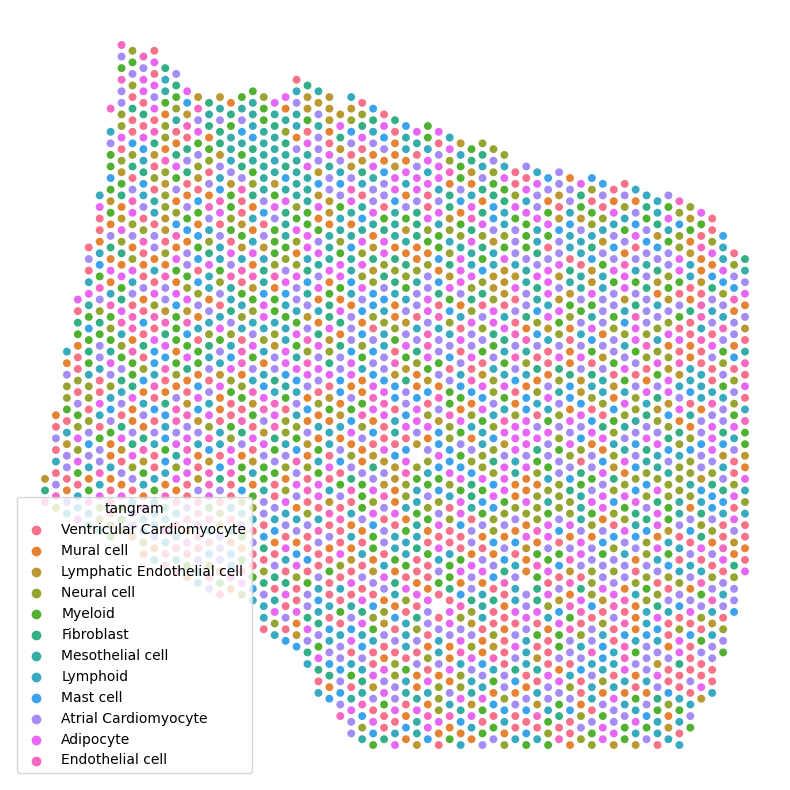

In [121]:
adata_st.obs.loc[:, 'tangram'] = tangram['tangram'].values
adata_st.obsm['spatial'] = adata_st.obsm['X_spatial']
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
plot_spatial(
    adata_st,
    annotation=f"tangram",
    spot_size=260,
    ax=axs
)

In [129]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sc.pl.spatial(adata_st, color='tangram', library_id=None, spot_size=0.01, groups=['Neural cell'], ax=axs)
plt.show()# ['HCAHeartST8795933', 'HCAHeartST9383352', 'HCAHeartST9383354', 'HCAHeartST9383356', 'HCAHeartST9383358']

In [91]:
# adata_st = sc.read_h5ad('../GSE121893_heart_4933_cells_ssi.h5ad')
# adata_st

In [92]:
# cell_type_mapping = {
#     'AV': 'Pericytes',
#     'EC1': 'Endothelium',
#     'EC2': 'Endothelium',
#     'EC3': 'Endothelium',
#     'EC4': 'Endothelium',
#     'EC5': 'Endothelium',
#     'EC6': 'Endothelium',
#     'EC7': 'Endothelium',
#     'FB1': 'Fibroblasts',
#     'FB2': 'Fibroblasts',
#     'FB3': 'Fibroblasts',
#     'FB4': 'Fibroblasts',
#     'FB5': 'Fibroblasts',
#     'FB6': 'Fibroblasts',
#     'LA1': 'Unknown',
#     'LA2': 'Unknown',
#     'LA3': 'Unknown',
#     'LA4': 'Unknown',
#     'LA5': 'Unknown',
#     'LA6': 'Unknown',
#     'LV1': 'Unknown',
#     'LV2': 'Unknown',
#     'LV3': 'Unknown',
#     'LV4': 'Unknown',
#     'LV5': 'Unknown',
#     'LV6': 'Unknown',
#     'LV7': 'Unknown',
#     'MP1': 'Macrophages',
#     'MP2': 'Macrophages',
#     'MP3': 'Macrophages',
#     'MP4': 'Macrophages',
#     'SMC1': 'Smooth_Muscle',
#     'SMC2': 'Smooth_Muscle',
#     'SMC3': 'Smooth_Muscle',
#     'SMC4': 'Smooth_Muscle',
#     'SMC5': 'Smooth_Muscle'
# }
# adata_st.obs.loc[:, 'cell_type_mapped'] = [cell_type_mapping[x] for x in adata_st.obs['cell_type']]

In [93]:
# cm = contingency_matrix(adata_st.obs.loc[:, 'annotation_final'], adata_st.obs.loc[:, 'ssi'])
# # Visualize the confusion matrix using Seaborn
# class_labels_y = np.unique(adata_st.obs.loc[:, 'annotation_final'])
# class_labels_x = np.unique(adata_st.obs.loc[:, 'ssi'])

# plt.figure(figsize=(8,8))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels_x, yticklabels=class_labels_y)
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Contingency Matrix")
# plt.show()

In [94]:
# Calculate marker genes
# sc.pp.normalize_total(adata_st, target_sum=1e4)
# sc.pp.log1p(adata_st)
# adata_st.var_names_make_unique()
# adata_st = adata_st[adata_st.obs['ssi'] != 'Mural cell'].copy()
adata_st = adata_st[adata_st.obs['ssi'] != 'Lymphatic Endothelial cell'].copy()

sc.tl.rank_genes_groups(adata_st, groupby='ssi', use_raw=False)

In [95]:
markers_df = pd.DataFrame(adata_st.uns["rank_genes_groups"]["names"])
pval_df = pd.DataFrame(adata_st.uns["rank_genes_groups"]["pvals_adj"])
markers_per_type_dict = {}
for col in markers_df.columns:
    markers_per_type_dict[col] = markers_df.loc[pval_df[col] < 0.05, col].values
len(markers_per_type_dict['Neural cell'])

4653

In [96]:
markers_per_type_dict.keys()

dict_keys(['Atrial Cardiomyocyte', 'Endothelial cell', 'Fibroblast', 'Mesothelial cell', 'Mural cell', 'Myeloid', 'Neural cell', 'Ventricular Cardiomyocyte'])

In [97]:
adata_st.var

features
AL627309.5  AL627309.5
LINC01409    LINC01409
LINC01128    LINC01128
FAM41C          FAM41C
SAMD11          SAMD11
...                ...
AC011043.1  AC011043.1
AL592183.1  AL592183.1
AC004556.3  AC004556.3
AC136616.1  AC136616.1
AC007325.4  AC007325.4

[14492 rows x 1 columns]

In [98]:

# Tyrosine Hydroxylase (TH):
# Explanation: TH is commonly associated with the synthesis of catecholamines, including norepinephrine. Neurons expressing TH are often related to the sympathetic nervous system, which influences cardiac function.
# Reference: Goldstein, D. S., & Eisenhofer, G. (2011). A clinical perspective: Autonomic failure as the key initial feature of Parkinson's disease. Neurology, 77(6), 552-558.


# Choline Acetyltransferase (CHAT):
# Explanation: CHAT is involved in acetylcholine synthesis, a neurotransmitter found in parasympathetic neurons that regulate heart rate.
# Reference: Gibbons, D. D., & Kreider, M. S. (1987). The synthesis and localization of acetylcholine in the heart. Journal of Neuroscience Research, 18(2), 157-167.

# Vasoactive Intestinal Peptide (VIP):
# Explanation: VIP is a neurotransmitter found in some intrinsic cardiac neurons, playing a role in neurotransmission.
# Reference: Suleiman, S. A., et al. (2003). Cardiac neuronal hierarchy in health and disease. American Journal of Physiology-Heart and Circulatory Physiology, 285(5), H1774-H1781.

# Nitric Oxide Synthase 1 (NOS1):
# Explanation: NOS1 is involved in nitric oxide production, and its expression in neurons suggests a role in cardiac regulation.
# Reference: Kanai, A. J., et al. (2001). Neuronal nitric oxide synthase modulates basal and β-adrenergic-stimulated contractility in murine ventricular myocytes. Circulation, 104(25), 2962-2967.

# Calretinin:
# Explanation: Calretinin is a calcium-binding protein found in some cardiac neurons, indicating a neuronal population.
# Reference: Sabrià, J., et al. (2005). Calretinin, parvalbumin, and calbindin-D28k in human heart. An immunohistochemical study. Annals of Anatomy - Anatomischer Anzeiger, 187(4), 321-328.

# HuC/HuD (Neuronal RNA-binding proteins):
# Explanation: HuC/HuD are neuronal RNA-binding proteins expressed in various neuronal populations.
# Reference: Marusich, M. F., et al. (1994). Cloning and characterization of HuR, a ubiquitously expressed Elav-like protein. Journal of Biological Chemistry, 269(26), 20796-20802.

# Neurofilament Proteins (NEFL, NEFM, NEFH):
# Explanation: Neurofilament proteins are structural components of neurons, providing support to the cell.
# Reference: Lee, M. K., & Cleveland, D. W. (1996). Neuronal intermediate filaments. Annual Review of Neuroscience, 19, 187-217.


neuron_heart_marker_genes = [
    "TH",           # Tyrosine Hydroxylase
    "CHAT",         # Choline Acetyltransferase
    "VIP",          # Vasoactive Intestinal Peptide
    "NOS1",         # Nitric Oxide Synthase 1
    "Calretinin",   # Calretinin  NOT present
    "HuC/HuD",      # Neuronal RNA-binding proteins  NOT present
    "NEFL",         # Neurofilament Light (NEFL)
    "NEFM",         # Neurofilament Medium (NEFM)
    "NEFH"          # Neurofilament Heavy (NEFH)
]
for gene in neuron_heart_marker_genes:
    out = ''
    if gene not in adata_st.var.index:
        out = (f'Gene {gene} does not exist')
    else:
        if gene not in markers_per_type_dict['Neural cell']:
            out = f'{gene} NOT MARKER '
        else:
            out += '{}: p-val = {}'.format(gene, pval_df.loc[ markers_df[markers_df['Neural cell'] == gene].index, 'Neural cell' ].values[0])
    print(out)


Gene TH does not exist
Gene CHAT does not exist
VIP: p-val = 0.004343787017836105
Gene NOS1 does not exist
Gene Calretinin does not exist
Gene HuC/HuD does not exist
Gene NEFL does not exist
Gene NEFM does not exist
Gene NEFH does not exist


In [59]:
for gene in (adata_st.var.index):
    if 'nef' in gene.lower():
        print(gene)

In [16]:
adata_st.obs[adata_st.obs['sc_type'] == 'Neurons']

nGene    nUMI condition group sample cell_type  Age  sc_type  \
cell_id                                                                        
SC_96355_70_32   2578   12948    dHF_LV   NCM     D2      SMC1   51  Neurons   
SC_96355_30_16   4785  131641    dHF_LV   NCM     D2       MP4   51  Neurons   
SC_96407_54_70   1029    4926    dHF_LA   NCM     D2       FB2   51  Neurons   
SC_96407_27_68   1207    4129    dHF_LA   NCM     D2       EC6   51  Neurons   

                confidence cell_type_mapped  
cell_id                                      
SC_96355_70_32        0.65    Smooth_Muscle  
SC_96355_30_16        0.45      Macrophages  
SC_96407_54_70        0.35      Fibroblasts  
SC_96407_27_68        0.65      Endothelium

<Axes: xlabel='confidence', ylabel='Count'>

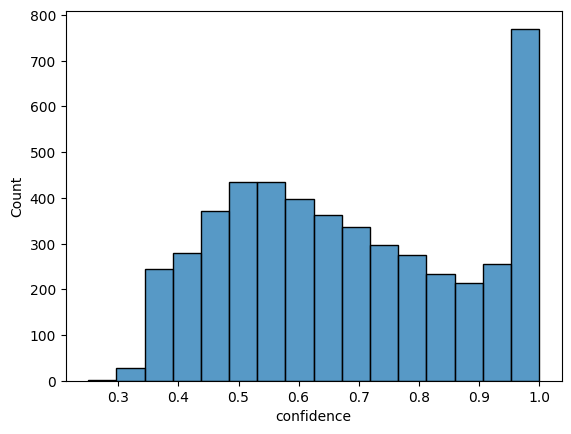

In [17]:
sns.histplot(adata_st.obs['confidence'])

In [7]:
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import seaborn as sns
# Visualisation
def plot_spatial(
    adata, annotation, ax: Axes, spot_size: float, palette=None, title: str = ""
):
    """
    Scatter plot in spatial coordinates.

    Parameters:
        - adata (AnnData): Annotated data object which represents the sample
        - annotation (str): adata.obs column used for grouping
        - ax (Axes): Axes object used for plotting
        - spot_size (int): Size of the dot that represents a cell. We are passing it as a diameter of the spot, while
                the plotting library uses radius therefore it is multiplied by 0.5
        - palette (dict): Dictionary that represents a mapping between annotation categories and colors
        - title (str): Title of the figure

    """
    s = spot_size * 0.5
    data = adata
    ax = sns.scatterplot(
        data=data.obs,
        hue=annotation,
        x=data.obsm["spatial"][:, 0],
        y=data.obsm["spatial"][:, 1],
        ax=ax,
        s=s,
        linewidth=0,
        palette=palette,
        marker=".",
    )
    ax.invert_yaxis()
    ax.set(yticklabels=[], xticklabels=[], title=title)
    ax.tick_params(bottom=False, left=False)
    ax.set_aspect("equal")
    sns.despine(bottom=True, left=True, ax=ax)


# fig, axs = plt.subplots(1, 1, figsize=(14, 14))
# sns.histplot(adata_st.obs["sc_type"], ax=axs[0][0])
# plot_spatial(
#     adata_st,
#     annotation=f"sc_type",
#     spot_size=30,
#     ax=axs,
# )
# plot_spatial(
#     adata_st, annotation="in_tissue", spot_size=30, ax=axs[1]
# )
# plt.savefig(f"ssi_visium_brain.png", dpi=120, bbox_inches="tight")
